In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import time

In [3]:
path_to_file = '/content/drive/My Drive/Colab Notebooks/'
diab_df = pd.read_csv(path_to_file+'diabetes.csv', sep=',')

diab_df.head(5)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
print ('dataframe shape; ', diab_df.shape)
print ('look for null values in the dataframe: ' )
print ('null values in entire dataframe: ', diab_df.isnull().values.any())
print ('total number of null values: ', diab_df.isnull().sum().sum())

### no null values   but...

dataframe shape;  (768, 9)
look for null values in the dataframe: 
null values in entire dataframe:  False
total number of null values:  0


In [5]:
print ('number of positive (1) and negative (0) diabetic patients: ', '\n', diab_df.Outcome.value_counts())

number of positive (1) and negative (0) diabetic patients:  
 0    500
1    268
Name: Outcome, dtype: int64


In [6]:
diab_df.rename(columns={'DiabetesPedigreeFunction': 'DiabPedgFunct'}, inplace=True)

print ('check dataframe columns :', diab_df.columns)

check dataframe columns : Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabPedgFunct', 'Age', 'Outcome'],
      dtype='object')


#### Dealing with Missing Values

Even though there are no null or NaN values, in the dataframe head we saw that there are zero values in Insulin column, which is impossible. So first we check for 0 values in specific columns (Glucose, BloodPressure, SkinThickness, Insulin, BMI) where measuring 0 does not make sense (should be treated as missing value). We can check later that Age column has no 0 values.    

First we count the number of missing values in these columns.  


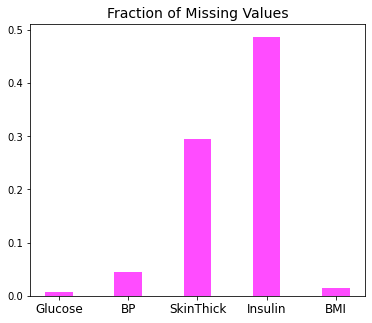

In [7]:
glucose_val_count0 = diab_df['Glucose'].value_counts()[0]
# print (glucose_val_count0)

bp_val_count0 = diab_df['BloodPressure'].value_counts()[0]
# print (bp_val_count0)

skin_th_count0 = diab_df['SkinThickness'].value_counts()[0]
# print (skin_th_count0)

insulin_count0 = diab_df['Insulin'].value_counts()[0]
# print(insulin_count0)

BMI_count0 = diab_df['BMI'].value_counts()[0]
# print(BMI_count0)

# Age_count0 = diab_df['Age'].value_counts()[30]
# print (Age_count0) # no zero values for age, gives a keyerror 

val_list0 = [glucose_val_count0/diab_df.shape[0], bp_val_count0/diab_df.shape[0], skin_th_count0/diab_df.shape[0], 
             insulin_count0/diab_df.shape[0], BMI_count0/diab_df.shape[0]]

labels0 = ['Glucose', 'BP', 'SkinThick', 'Insulin', 'BMI'] 
x = np.arange(len(labels0))

fig = plt.figure(figsize=(6, 5))
plt.bar(x, height=val_list0, width=0.4, align='center', color='magenta', alpha=0.7)
plt.xticks(ticks=x, labels=labels0, fontsize=12)
plt.title('Fraction of Missing Values', fontsize=14)
plt.show()

## for insulin almost half the values are missing. 

**_Impute the Missing Values_**

As we see above almost half of the values under Insulin entry are missing. The other columns also have some missing values. We can check the distribution of the features before we decide how to impute the values.    

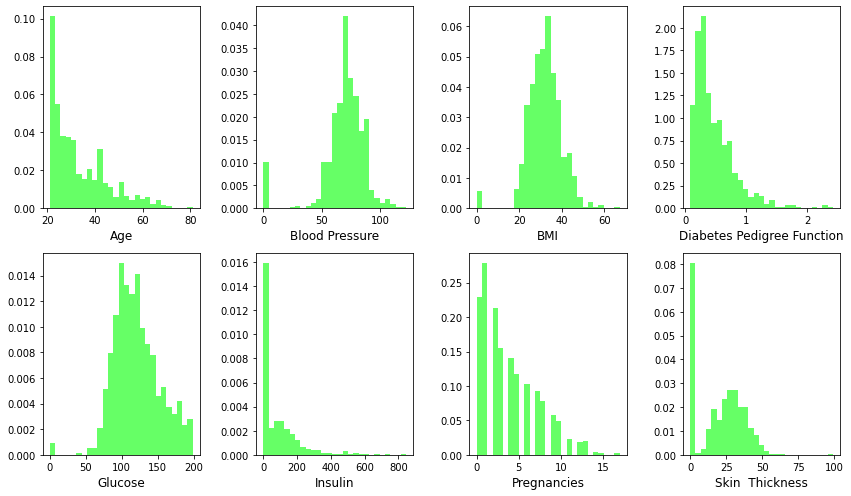

In [8]:
fig = plt.figure(figsize=(12, 7))
fig.add_subplot(241)
plt.hist(diab_df['Age'], bins=int(np.sqrt(diab_df.shape[0])), density= True, color='lime', alpha=0.6)
plt.xlabel('Age', fontsize=12)

fig.add_subplot(242)
plt.hist(diab_df['BloodPressure'], bins=int(np.sqrt(diab_df.shape[0])), density= True, color='lime', alpha=0.6)
plt.xlabel('Blood Pressure', fontsize=12)

fig.add_subplot(243)
plt.hist(diab_df['BMI'], bins=int(np.sqrt(diab_df.shape[0])), density= True, color='lime', alpha=0.6)
plt.xlabel('BMI', fontsize=12)

fig.add_subplot(244)
plt.hist(diab_df['DiabPedgFunct'], bins=int(np.sqrt(diab_df.shape[0])), density= True, color='lime', alpha=0.6)
plt.xlabel('Diabetes Pedigree Function', fontsize=12)

fig.add_subplot(245)
plt.hist(diab_df['Glucose'], bins=int(np.sqrt(diab_df.shape[0])), density= True, color='lime', alpha=0.6)
plt.xlabel('Glucose', fontsize=12)

fig.add_subplot(246)
plt.hist(diab_df['Insulin'], bins=int(np.sqrt(diab_df.shape[0])), density= True, color='lime', alpha=0.6)
plt.xlabel('Insulin', fontsize=12)

fig.add_subplot(247)
plt.hist(diab_df['Pregnancies'], bins=int(np.sqrt(diab_df.shape[0])), density= True, color='lime', alpha=0.6)
plt.xlabel('Pregnancies', fontsize=12)

fig.add_subplot(248)
plt.hist(diab_df['SkinThickness'], bins=int(np.sqrt(diab_df.shape[0])), density= True, color='lime', alpha=0.6)
plt.xlabel('Skin  Thickness', fontsize=12)

plt.tight_layout()
plt.show()

In [9]:
##### first let;s replace zeros with np.nan 
##### this will help us in imputation. 

diab_df[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = diab_df[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].replace(0, np.NaN)

As we see here, that distributions of Glucose, BloodPressure, SkinThickness, Insulin, BMI features look like gaussian distributions apart from the 0th bin. In that case best option is to replace 0 values with median (for normal distribution this should be same as mean and mode) of the distribution because we expect a large chunk of sample to lie around that value.  Use Pandas dataframe [repalce](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.replace.html) method. However since 'Insulin' and 'SkinThickness' have considerable fraction as missing, this strategy may backfire. Let's try !  

In [10]:
diab_df['BMI_New'] = diab_df['BMI'].replace(np.NaN, diab_df['BMI'].mean())
diab_df['BloodPressure_New'] = diab_df['BloodPressure'].replace(np.NaN, diab_df['BloodPressure'].mean())
diab_df['Glucose_New'] = diab_df['Glucose'].replace(np.NaN, diab_df['Glucose'].mean())
diab_df['Insulin_New'] = diab_df['Insulin'].replace(np.NaN, diab_df['Insulin'].mean())
diab_df['SkinThickness_New'] = diab_df['SkinThickness'].replace(np.NaN, diab_df['SkinThickness'].mean())

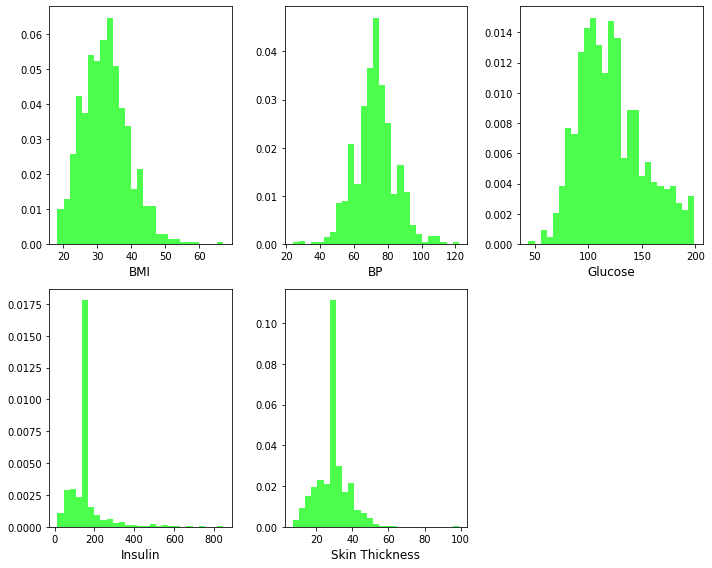

In [11]:
#### check the distributions again  
fig = plt.figure(figsize=(10, 8))

fig.add_subplot(231)
plt.hist(diab_df['BMI_New'], density=True, bins=int(np.sqrt(diab_df.shape[0])), color='lime', alpha=0.7)
plt.xlabel('BMI', fontsize=12)

fig.add_subplot(232)
plt.hist(diab_df['BloodPressure_New'], density=True, bins=int(np.sqrt(diab_df.shape[0])), color='lime', alpha=0.7)
plt.xlabel('BP', fontsize=12)

fig.add_subplot(233)
plt.hist(diab_df['Glucose_New'], density=True, bins=int(np.sqrt(diab_df.shape[0])), color='lime', alpha=0.7)
plt.xlabel('Glucose', fontsize=12)

fig.add_subplot(234)
plt.hist(diab_df['Insulin_New'], density=True, bins=int(np.sqrt(diab_df.shape[0])), color='lime', alpha=0.7)
plt.xlabel('Insulin', fontsize=12)

fig.add_subplot(235)
plt.hist(diab_df['SkinThickness_New'], density=True, bins=int(np.sqrt(diab_df.shape[0])), color='lime', alpha=0.7)
plt.xlabel('Skin Thickness', fontsize=12)

plt.tight_layout()

In [ ]:
print (max(diab_df['BMI_New']))

67.1


Here we see first problem, even though the distributions for BMI, BP and Glucose looks reasonable but the Insulin and Skin Thickness distribution looks odd because of our imputing strategy. So for these 2 distributions we have to consider taking different strategy. We will do an interpolation to fill the NaNs. 

For Skin thickness and Insulin we do a linear interpolation. This method is available for Pandas Series. [Interpolation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.interpolate.html). Pandas has a nice [documentation](https://pandas.pydata.org/pandas-docs/stable/user_guide/missing_data.html) about different ways to handle missing data. 

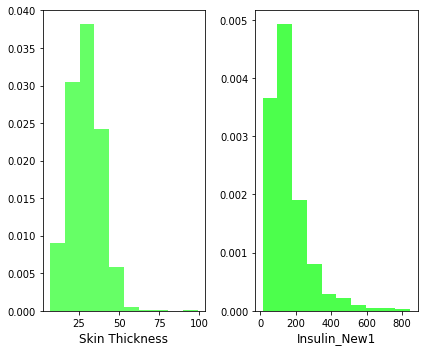

In [12]:
diab_df = diab_df.astype(float)
diab_df['SkinThickness_New1'] = diab_df.SkinThickness.interpolate(method='linear', limit = 400, limit_direction='forward')
diab_df['Insulin_New1'] = diab_df.Insulin.interpolate(method='linear', limit=800, limit_direction='both')


fig = plt.figure(figsize=(6, 5))

fig.add_subplot(121)
plt.hist(diab_df['SkinThickness_New1'], density=True, color='lime', alpha=0.6)
plt.xlabel('Skin Thickness', fontsize=12)

fig.add_subplot(122)
plt.hist(diab_df['Insulin_New1'], density=True, color='lime', alpha=0.7)
plt.xlabel('Insulin_New1', fontsize=12)

plt.tight_layout()
plt.show()

In [13]:
# print (diab_df['Insulin_New1'].value_counts())
print ('Insulin max and min; ', max(diab_df['Insulin_New1']) , min(diab_df['Insulin_New1']))
print ('skin thickness max and min; ', max(diab_df['SkinThickness_New1']), min(diab_df['SkinThickness_New1']))
# print (diab_df['SkinThickness_New1'].value_counts()[0])

Insulin max and min;  846.0 14.0
skin thickness max and min;  99.0 7.0


After successful imputation we now keep only the relevant columns. 
Then we will study based on the outcome how each feature varies. 

In [14]:
#### select the relevant features
diab_df_selected = diab_df[['Pregnancies', 'Glucose_New', 'BloodPressure_New', 'SkinThickness_New1', 'Insulin_New1',
       'BMI_New', 'DiabPedgFunct', 'Age', 'Outcome']]   

In [15]:
features = diab_df_selected.drop(['Outcome'], axis=1)

features_arr = features.to_numpy()
feature_names_list = features.columns.to_list()

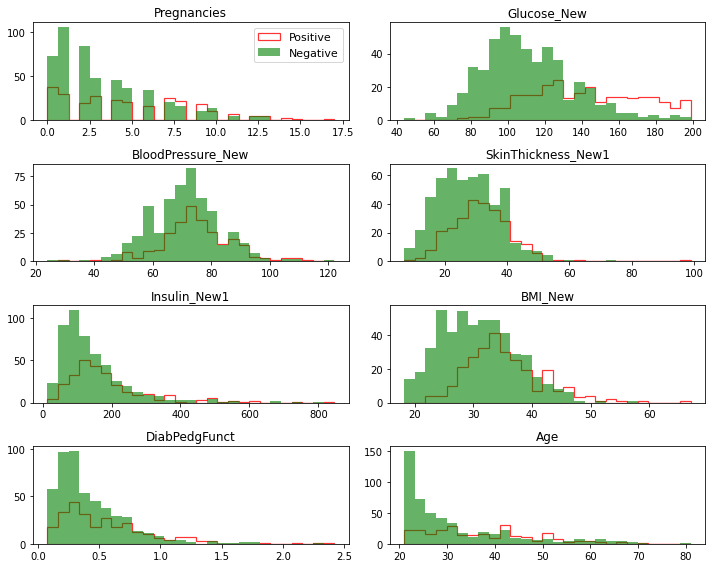

In [16]:
positive_diab = features_arr[diab_df_selected.Outcome==1]
negative_diab = features_arr[diab_df_selected.Outcome==0]

fig,axes =plt.subplots(4,2, figsize=(10, 8))
ax = axes.ravel()

for i in range(8):
	_,bins= np.histogram(features_arr[:, i], bins=int(np.sqrt(768)) )
	# plt.close()
	ax[i].hist(positive_diab[:, i], bins=bins, histtype='stepfilled', edgecolor='red', linewidth=1.2, fill=False, alpha=0.8,)
	ax[i].hist(negative_diab[:, i], bins=bins, color='green', alpha=0.6)
	ax[i].set_title(feature_names_list[i],fontsize=12)
	# ax[i].axes.get_xaxis().set_visible(False)	
	# ax[i].set_yticks(())
ax[0].legend(['Positive','Negative'],loc='best',fontsize=11)
plt.tight_layout()	
plt.show() ### from the age distribution we can categorically say that young people have less chance of diabetes.  

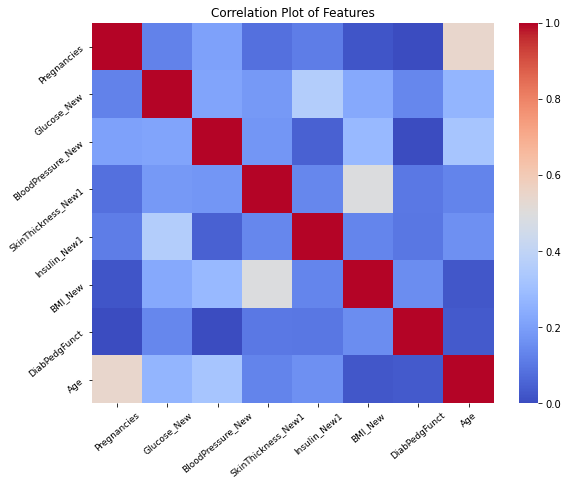

In [17]:
# features = list(diab_df_selected.columns[0:7])
# feature_corr = diab_df_selected[features].corr() # alternate way 


feature_corr = features.corr() 

fig = plt.figure(figsize=(9, 7))
g1 = sns.heatmap(feature_corr, cmap='coolwarm', vmin=0., vmax=1., )
g1.set_xticklabels(g1.get_xticklabels(), rotation=40, fontsize=9)
g1.set_yticklabels(g1.get_yticklabels(), rotation=40, fontsize=9)
plt.title('Correlation Plot of Features', fontsize=12)
plt.show()

# the correlation between the variables are very low. Some moderate correlation between
# Age and Pregnancy; and BMI_New and BloodPressure_New.  So we can ignore proceeding via PCA (this is for ML part). 
# see the feature dependence in detail with the pair plot. 

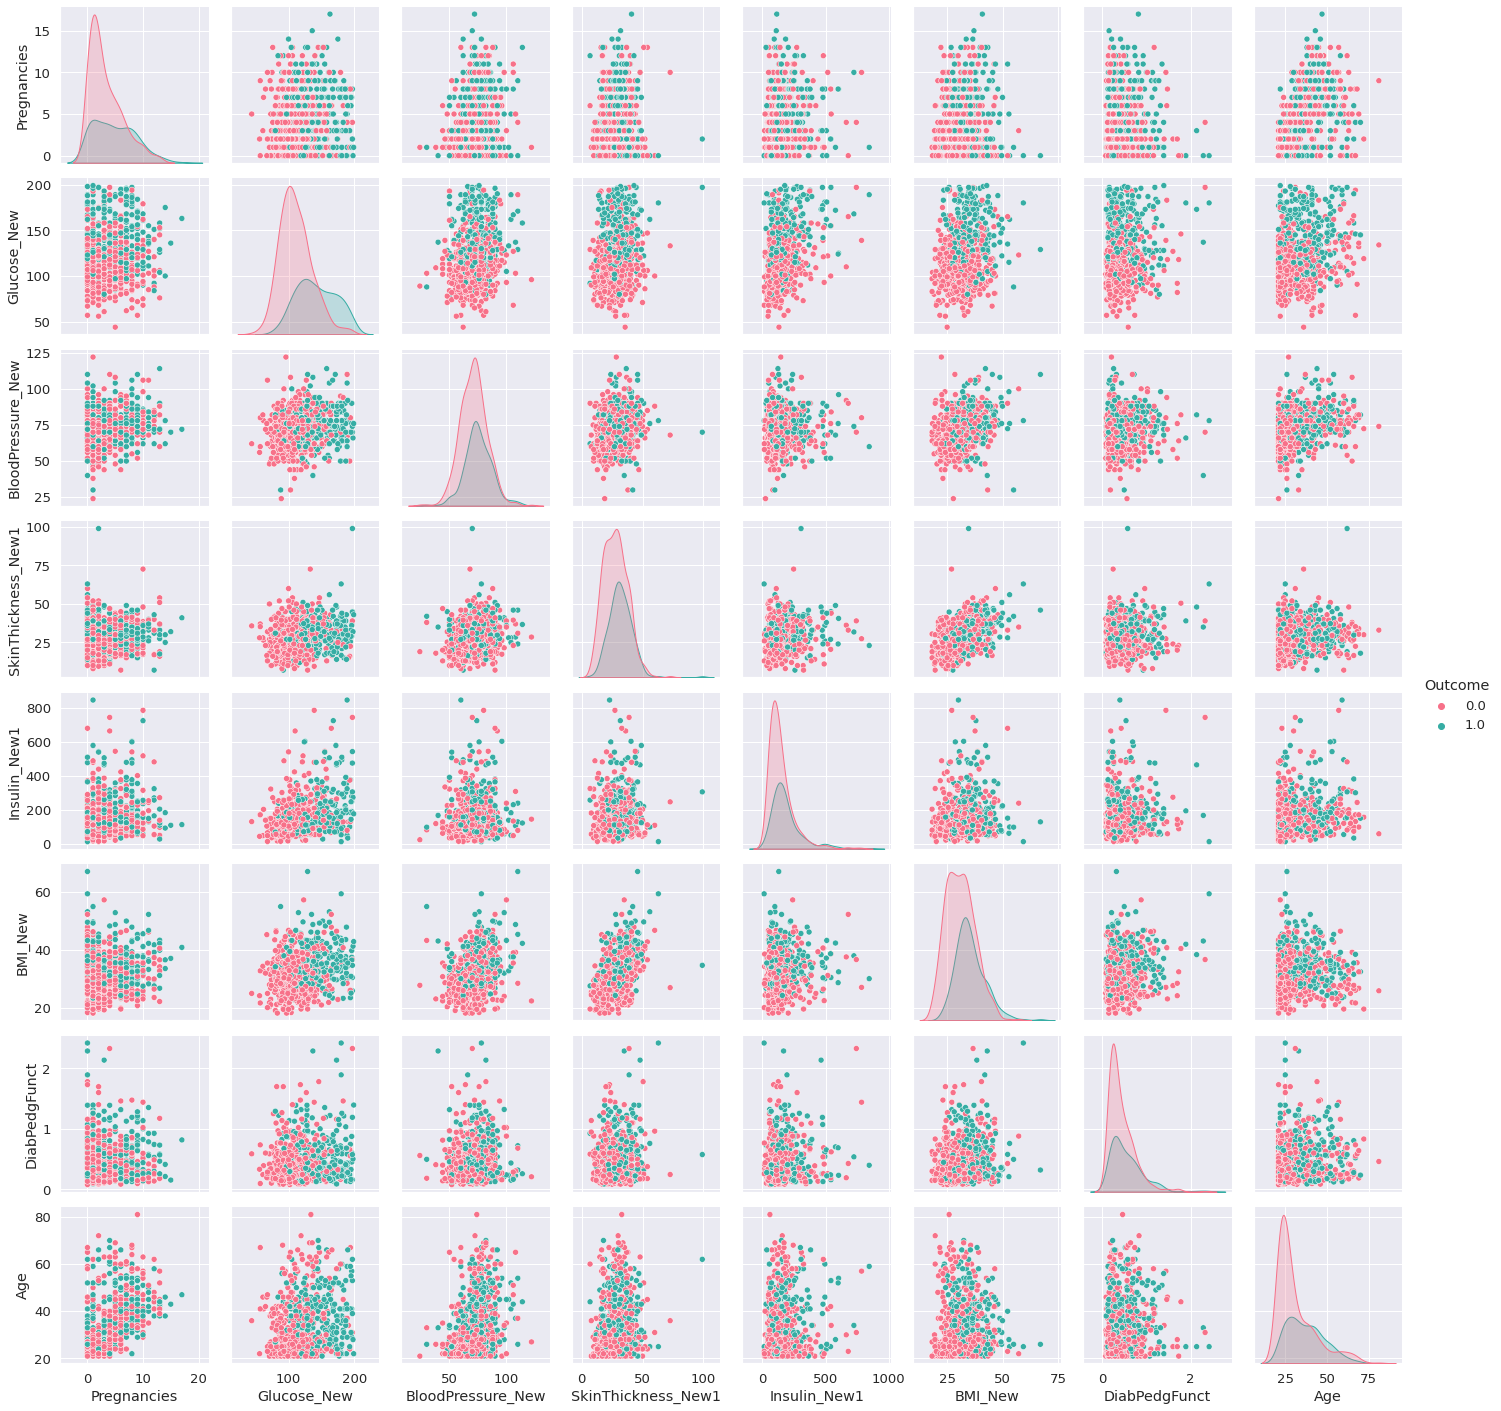

In [18]:
# seaborn pair plot 
sns.set(font_scale=1.2)
sns.pairplot(diab_df_selected, hue='Outcome', palette='husl')

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


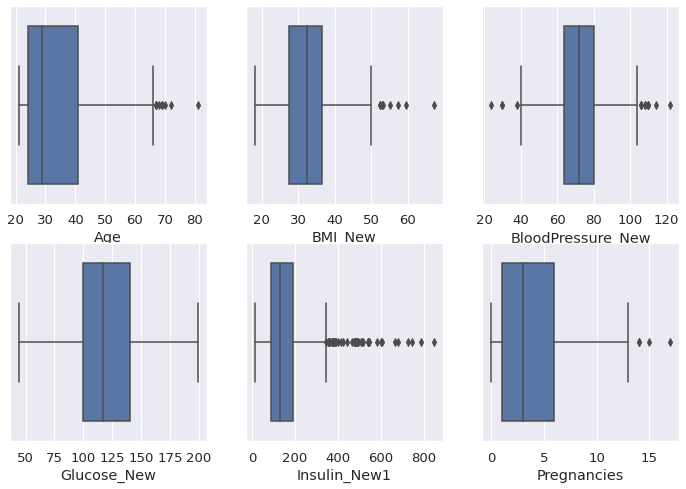

In [19]:
#### Make Box Plot of features to understand 

f, axes = plt.subplots(2, 3, figsize=(12, 8))
# print (axes.shape)
sns.set(font_scale=0.8)
sns.boxplot(x=diab_df_selected['Age'], ax=axes[0][0],)
sns.boxplot(x=diab_df_selected['Glucose_New'], ax=axes[1][0])
sns.boxplot(x=diab_df_selected['Insulin_New1'], ax=axes[1][1]) ### many outliers !!!
sns.boxplot(x=diab_df_selected['BMI_New'], ax=axes[0][1])
sns.boxplot(x=diab_df_selected['BloodPressure_New'], ax=axes[0][2])
sns.boxplot(diab_df_selected['Pregnancies'], ax=axes[1][2])

In [20]:
#### Try to reduce the number of outliers
print (diab_df_selected['Insulin_New1'].describe())

count    768.000000
mean     158.791016
std      111.453090
min       14.000000
25%       88.000000
50%      130.000000
75%      190.125000
max      846.000000
Name: Insulin_New1, dtype: float64


In [21]:
### let's try selecting based on Z score, 
### consider 3sigma std so that 99.7% data are included and everything beyond that would be considered as outliers and we neglect those values.

diab_df_selected_Zscore = diab_df_selected[(np.abs(stats.zscore(diab_df_selected)) < 3).all(axis=1)]

In [22]:
print ('check new dataframe shape: ', diab_df_selected_Zscore.shape) # 50 rows are gone

check new dataframe shape:  (718, 9)


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


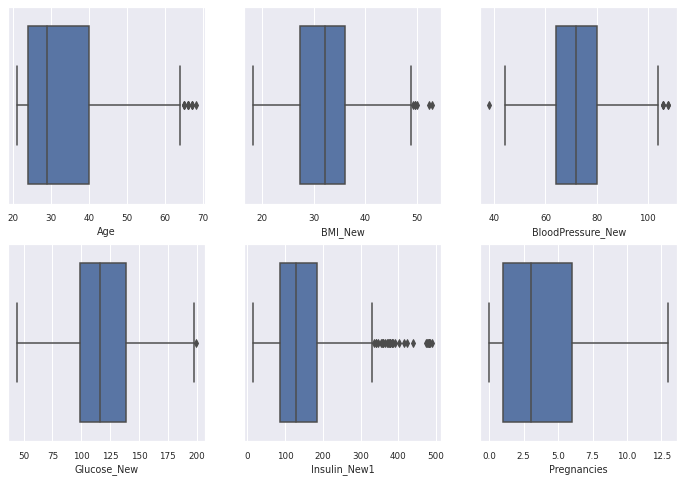

In [23]:
#### let's plot the boxplots again 

f, axes = plt.subplots(2, 3, figsize=(12, 8))
sns.set(font_scale=0.8)
sns.boxplot(x=diab_df_selected_Zscore['Age'], ax=axes[0][0],)
sns.boxplot(x=diab_df_selected_Zscore['Glucose_New'], ax=axes[1][0])
sns.boxplot(x=diab_df_selected_Zscore['Insulin_New1'], ax=axes[1][1]) 
sns.boxplot(x=diab_df_selected_Zscore['BMI_New'], ax=axes[0][1])
sns.boxplot(x=diab_df_selected_Zscore['BloodPressure_New'], ax=axes[0][2])
sns.boxplot(diab_df_selected_Zscore['Pregnancies'], ax=axes[1][2])

### All plots have considerably reduced outliers !!! This will make training and testing different classifier more meaningful. 

In [24]:
 
Outcome_arr = diab_df_selected_Zscore['Outcome'].to_numpy()
features_Zscore = diab_df_selected_Zscore.drop(['Outcome'], axis=1)
features_Zscore_arr = features_Zscore.to_numpy()
### Since the positive and negative samples are not equally distributed, we will use stratify

print ('check shapes for features and outcome: ', features_Zscore_arr.shape, Outcome_arr.shape)

check shapes for features and outcome:  (718, 8) (718,)


In [25]:

### First get started with train test split

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features_Zscore_arr, Outcome_arr, test_size=0.20, random_state=42, shuffle=True, stratify=Outcome_arr)

print ('check shape of training data: ', X_train.shape, y_train.shape)
print ('check shape of test data: ', X_test.shape, y_test.shape)

check shape of training data:  (574, 8) (574,)
check shape of test data:  (144, 8) (144,)


In [ ]:
### classifiers that we would like to check
### logistic regression, Random Forest, SVM, Naive Bayes 
### Build a pipleline to check the best classifier. 

### First we standardize the data due to difference in scaling of various features. 



In [26]:
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline



pipelines = [ [('scaler', StandardScaler()), ('SVM', SVC())], [('scaler', StandardScaler()), ('LR', LogisticRegression())], 
             [ ('RF', RandomForestClassifier())],  [('ADB', AdaBoostClassifier(DecisionTreeClassifier(max_depth=2)))], 
             [('scaler', StandardScaler()), ('GNB', GaussianNB())]]
# tree based models doesn't depend on scaling. 

svm_param_grid = {'SVM__C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 30, 40, 50, 75, 100, 200],  
                  'SVM__kernel': ['linear']}
LR_param_grid = {'LR__C': [0.01, 0.05, 0.1, 0.5, 1., 2., 5., 10.], 'LR__class_weight':['balanced']}

RF_param_grid = {'RF__criterion': ['gini', 'entropy'], 'RF__n_estimators': [30, 50, 75, 100, 125, 150, 200], 'RF__max_depth': [2, 3, 4]}

ADB_param_grid = {'ADB__n_estimators': [20, 40, 50, 75, 100, 200], 'ADB__learning_rate': [0.01, 0.05, 0.1, 0.5, 1., 2]}

GNB_param_grid = {'GNB__priors': [[0.35, 0.65], [0.4, 0.6]], 'GNB__var_smoothing': [1e-9, 1e-8]}

all_param_grid = [svm_param_grid, LR_param_grid, RF_param_grid, ADB_param_grid, GNB_param_grid]

In [27]:

all_pipelines = []

for p in pipelines:
  all_pipelines.append(Pipeline(p))
print ('check one of the pipelines: ', all_pipelines[0])  

check one of the pipelines:  Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('SVM',
                 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma='scale', kernel='rbf', max_iter=-1,
                     probability=False, random_state=None, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)


In [28]:
from tqdm.notebook import tqdm

grid_scores = []
grid_best_params = []

time1 = time.time()

for x in tqdm(range(len(all_pipelines))):
  grid = GridSearchCV(all_pipelines[x], param_grid=all_param_grid[x], cv=5)
  grid.fit(X_train, y_train)
  score = grid.score(X_test, y_test)
  grid_scores.append(score)
  grid_best_params.append(grid.best_params_)
print ('!!!!! out of the loop !!!!!')  
print ('time taken: ', time.time() - time1, 'seconds')


!!!!! out of the loop !!!!!
time taken:  74.0006914138794 seconds


In [29]:
print ('check best params: \n', grid_best_params)

check best params: 
 [{'SVM__C': 0.01, 'SVM__kernel': 'linear'}, {'LR__C': 0.5, 'LR__class_weight': 'balanced'}, {'RF__criterion': 'gini', 'RF__max_depth': 3, 'RF__n_estimators': 150}, {'ADB__learning_rate': 0.1, 'ADB__n_estimators': 40}, {'GNB__priors': [0.4, 0.6], 'GNB__var_smoothing': 1e-09}]


In [30]:
models = ['SVM', 'Logistic Reg', 'Random Forest', 'AdaBoost', 'GaussianNB']
score_dict = dict(zip(models, grid_scores))
print ('check best scores: \n', score_dict)

check best scores: 
 {'SVM': 0.7847222222222222, 'Logistic Reg': 0.7708333333333334, 'Random Forest': 0.7361111111111112, 'AdaBoost': 0.75, 'GaussianNB': 0.7291666666666666}


In [31]:
score_df = pd.DataFrame(score_dict.items(), columns=['Models', 'Score']) 

In [32]:
print (score_df)

          Models     Score
0            SVM  0.784722
1   Logistic Reg  0.770833
2  Random Forest  0.736111
3       AdaBoost  0.750000
4     GaussianNB  0.729167
